<a href="https://colab.research.google.com/github/braxtonowens/Sample_GBDB/blob/main/5D_space_asr_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google's Python Environment does not have dscribe(library used to run SOAP) Installed.
# The use of ! in the cell runs terminal command.
# This takes a few minutes to Download :( 
!pip install dscribe
!pip install ase

In [2]:
!pip install --upgrade matplotlib

In [3]:
!git clone https://github.com/braxtonowens/Sample_GBDB.git


fatal: destination path 'Sample_GBDB' already exists and is not an empty directory.


In [4]:
#Use ASE to read LAMMPS output files
import ase.io
import os

gbpath = '/content/Sample_GBDB/data_lammps_out'
atoms = []
for i,file in enumerate(os.listdir(gbpath)):
  atoms.append(ase.io.read(os.path.join(gbpath,file)))
  atoms[i].set_atomic_numbers([13 for i in atoms[i]])

In [5]:
# Calculate SOAP for 100 gbs
# This will take a few minutes

from dscribe.descriptors import SOAP

species = ['Al']
rcut = 6.0
nmax = 8
lmax = 6

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
)

allsoap = soap.create(atoms)

In [6]:
def trim_soap(gb, soap, rcut, dim=2):
    # trim off slice of width rcut from the very top and bottom of the GB
    gbCenter = 0
    positions = gb.positions[:, dim]
    trim_top = max(positions)-rcut
    trim_bot = min(positions)+rcut
    idx_del = np.where(np.logical_or(positions > trim_top, positions < trim_bot))[0]

    #delete the given indices from soap along the 0 axis
    trimmed_soap = np.delete(soap,idx_del,0)
    return trimmed_soap

In [7]:
import numpy as np
for i,atom in enumerate(allsoap):
    gb = atoms[i]
    result = trim_soap(gb, allsoap[i], 3.74)

In [8]:
def asr(allsoap, norm_asr=False):
    # for each gb, average and add to matrix, and return
    asr_matrix = []
    magnitude = 1
    for soap in allsoap:
        asr_row = np.average(soap, axis=0)
        if norm_asr is True:
            magnitude = np.linalg.norm(asr_row)
        asr_matrix.append(asr_row / magnitude)
    return np.array(asr_matrix)

In [9]:
asrvec = asr(allsoap)
energies = np.load('/content/Sample_GBDB/energies.npy')
print(np.shape(asrvec))
print(np.shape(energies))

(100, 252)
(100,)


In [10]:
def split_train_test_id(X,Y,idtrain,idvalid):
    #split the data
    K_train = X[idtrain,:].dot(X[idtrain,:].T) #subset of kernel matrix corresponding to training data
    y_train = Y[idtrain]
    K_valid = X[idvalid,:].dot(X[idtrain,:].T)
    y_valid = Y[idvalid]
    
    #setup model
    Cvalhomer = 10000; gammavalhomer = 'scale'; #(C,gamma) = (1000,100) in Homer paper
    split_train_test.model = SVR(kernel='precomputed',C=Cvalhomer,gamma=gammavalhomer, verbose=False)
    
    #train the model
    split_train_test.model.fit(K_train, y_train)
    
    #make predictions
    y_pred_train = split_train_test.model.predict(K_train)
    y_pred_valid = split_train_test.model.predict(K_valid)
    
    #calculate RMSE
    train_rmse = np.sqrt(np.sum((y_pred_train - y_train)**2)/y_train.shape[0])
    valid_rmse = np.sqrt(np.sum((y_pred_valid - y_valid)**2)/y_valid.shape[0])
    #print('train RMS error: %f' % train_rmse)
    #print('valid RMS error: %f' % valid_rmse)
    
    return (y_train, y_valid, y_pred_train, y_pred_valid, train_rmse, valid_rmse)

In [11]:
def split_train_test(X_train,X_test,Y_train,Y_test):
    #split the data
    K_train = X_train.dot(X_train.T) #subset of kernel matrix corresponding to training data
    y_train = Y_train
    K_valid = X_test.dot(X_train.T)
    y_valid = Y_test
    
    #setup model
    Cvalhomer = 10000; gammavalhomer = 'scale'; #(C,gamma) = (1000,100) in Homer paper
    split_train_test.model = SVR(kernel='precomputed',C=Cvalhomer,gamma=gammavalhomer, verbose=False)
    
    #train the model
    split_train_test.model.fit(K_train, y_train)
    
    #make predictions
    y_pred_train = split_train_test.model.predict(K_train)
    y_pred_valid = split_train_test.model.predict(K_valid)
    
    #calculate RMSE
    train_rmse = np.sqrt(np.sum((y_pred_train - y_train)**2)/y_train.shape[0])
    valid_rmse = np.sqrt(np.sum((y_pred_valid - y_valid)**2)/y_valid.shape[0])
    #print('train RMS error: %f' % train_rmse)
    #print('valid RMS error: %f' % valid_rmse)
    
    return (y_train, y_valid, y_pred_train, y_pred_valid, train_rmse, valid_rmse)

In [12]:
import pandas as pd
df = pd.read_csv("/content/Sample_GBDB/Sample_Al_data.csv")
DisAngle = df.DisAngle #you can also use df['column_name']

# turn aid_column to list

list_DisAngle = DisAngle.tolist()
    
# 15 degree subset(split dataset by disangle 15 degree)

low_15_index_train = []
greater_15_index_test = []
for i in range(len(list_DisAngle)):
    if list_DisAngle[i] < 15:
        low_15_index_train.append(i)
    else:
        greater_15_index_test.append(i)
        
low_20_index_train = []
greater_20_index_test = []
for i in range(len(list_DisAngle)):
    if list_DisAngle[i] < 20:
        low_20_index_train.append(i)
    else:
        greater_20_index_test.append(i)


lowang_energy_15 = np.array([energies[i] for i in low_15_index_train])
highang_energy_15 = np.array([energies[i] for i in greater_15_index_test])

lowang_energy_20 = np.array([energies[i] for i in low_20_index_train])
highang_energy_20 = np.array([energies[i] for i in greater_20_index_test])

        
lowang_sum_15 = np.array([asrvec[i] for i in low_15_index_train])
highang_sum_15 = np.array([asrvec[i] for i in greater_15_index_test])

lowang_sum_20 = np.array([asrvec[i] for i in low_20_index_train])
highang_sum_20 = np.array([asrvec[i] for i in greater_20_index_test])

In [13]:
from matplotlib import pyplot as plt
from sklearn.svm import SVR


#Train on low angle data(< 15 degrees) and validate on high angle data

y_train_low, y_valid_low, y_pred_train_low, y_pred_valid_low, train_rmse_low, valid_rmse_low = split_train_test(lowang_sum_15,highang_sum_15,lowang_energy_15,highang_energy_15)

In [14]:
len(y_train_low)

1

In [15]:
#get one random cross val

from sklearn.svm import SVR
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle = True)

train_rmse_list = []
valid_rmse_list = []

i = 0; 
#save only first value
for train_index, test_index in kf.split(asrvec):
    if i==3:
        y_train_rand, y_valid_rand, y_pred_train_rand, y_pred_valid_rand, train_rmse_rand, valid_rmse_rand = split_train_test_id(asrvec,energies,train_index,test_index)
    i+=1

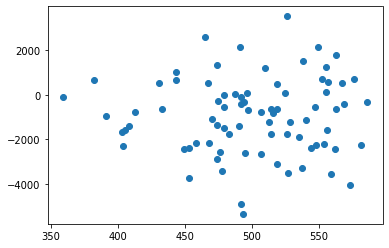

In [16]:
plt.scatter(y_train_rand, y_pred_train_rand)

In [17]:
import random

rng = np.random.default_rng()
rng.shuffle(asrvec,axis=0) #this shuffles x so be careful when reusing it elsewhere.
nGB=len(energies)
ids = range(0,nGB)
random.seed(9999)
idtrain = np.array(random.sample(ids,int(2*nGB/3))) #randomly select N parts of the ids
idvalid = np.array(list(set(ids).difference(set(idtrain))))

y_train_shuf, y_valid_shuf, y_pred_train_shuf, y_pred_valid_shuf, train_rmse_shuf, valid_rmse_shuf = split_train_test_id(asrvec,energies,idtrain,idvalid)

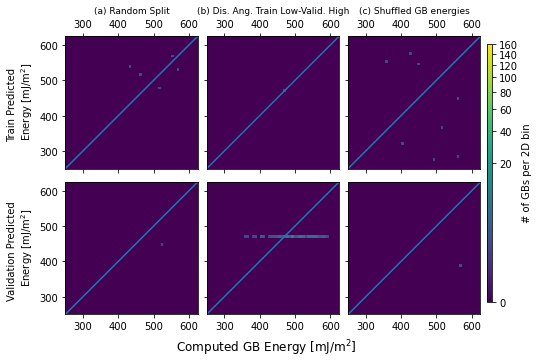

In [19]:


import matplotlib.colors as mcolors
cm = 1/2.54  # centimeters in inches
fig, axarr = plt.subplots(2, 3,figsize=(19*cm,13*cm),sharex=True, sharey=True)
fig.supxlabel('Computed GB Energy [mJ/m$^2$]')
#random cross val
im00 = axarr[0,0].hist2d(y_train_rand, y_pred_train_rand, bins=50,range=[[250, 625], [250, 625]], norm=mcolors.PowerNorm(.3, vmin=0, vmax=160), cmap=plt.cm.viridis)
axarr[0,0].plot([250,625],[250,625])
axarr[0,0].set_ylim(250,625)
axarr[0,0].set_xlim(250,625)
axarr[0,0].set_aspect('equal')

im10 = axarr[1,0].hist2d(y_valid_rand, y_pred_valid_rand, bins=50, range=[[250, 625], [250, 625]],norm=mcolors.PowerNorm(.3, vmin=0, vmax=160), cmap=plt.cm.viridis)
axarr[1,0].plot([250,625],[250,625])
axarr[1,0].set_ylim(250,625)
axarr[1,0].set_xlim(250,625)
axarr[1,0].set_aspect('equal')


#train low
im01 = axarr[0,1].hist2d(y_train_low, y_pred_train_low, bins=50, range=[[250, 625], [250, 625]], norm=mcolors.PowerNorm(.3, vmin=0, vmax=160),cmap=plt.cm.viridis)
axarr[0,1].plot([250,625],[250,625])
axarr[0,1].set_ylim(250,625)
axarr[0,1].set_xlim(250,625)
axarr[0,1].set_aspect('equal')

im11 = axarr[1,1].hist2d(y_valid_low, y_pred_valid_low, bins=50, range=[[250, 625], [250, 625]], norm=mcolors.PowerNorm(.3, vmin=0, vmax=160), cmap=plt.cm.viridis)
axarr[1,1].plot([250,625],[250,625])
axarr[1,1].set_ylim(250,625)
axarr[1,1].set_xlim(250,625)
axarr[1,1].set_aspect('equal')


#shuffle
im02 = axarr[0,2].hist2d(y_train_shuf, y_pred_train_shuf, bins=50, range=[[250, 625], [250, 625]], norm=mcolors.PowerNorm(.3, vmin=0, vmax=160), cmap=plt.cm.viridis)
axarr[0,2].plot([250,625],[250,625])
axarr[0,2].set_ylim(250,625)
axarr[0,2].set_xlim(250,625)
axarr[0,2].set_aspect('equal')

im12 = axarr[1,2].hist2d(y_valid_shuf, y_pred_valid_shuf, bins=50, range=[[250, 625], [250, 625]], norm=mcolors.PowerNorm(.3, vmin=0, vmax=160), cmap=plt.cm.viridis)
axarr[1,2].plot([250,625],[250,625])
axarr[1,2].set_ylim(250,625)
axarr[1,2].set_xlim(250,625)
axarr[1,2].set_aspect('equal')



fig.subplots_adjust(wspace=0.05, hspace=.1)
cbar_ax2 = fig.add_axes([.91, 0.16, 0.01, 0.7])
cbar = fig.colorbar(im12[3], cax=cbar_ax2,aspect=1)
cbar.set_label("# of GBs per 2D bin")

axarr[0,0].set_ylabel('Train Predicted \n Energy [mJ/m$^2$]')
axarr[1,0].set_ylabel('Validation Predicted \n Energy [mJ/m$^2$]')

axarr[0,0].set_title('(a) Random Split',fontsize=9)
axarr[0,1].set_title('(b) Dis. Ang. Train Low-Valid. High',fontsize=9)
axarr[0,2].set_title('(c) Shuffled GB energies',fontsize=9)
axarr[0,0].tick_params(top = True, labeltop=True)
axarr[0,1].tick_params(top=True, labeltop=True)
axarr[0,2].tick_params(top = True, labeltop=True)
# axarr[1,0].tick_params(top=True)
fig.savefig('final_plot.png',format='png',dpi=300)